# Sistem Klasifikasi Emosi menggunakan SVM

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

class LBPExtractor:
    """Local Binary Pattern feature extractor"""
    
    def __init__(self, radius=1, n_points=8):
        self.radius = radius
        self.n_points = n_points
    
    def extract_lbp(self, image):
        """Extract LBP features from grayscale image"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        h, w = image.shape
        lbp_image = np.zeros_like(image)
        
        # Generate sampling points
        angles = 2 * np.pi * np.arange(self.n_points) / self.n_points
        sample_points = np.array([
            [int(round(self.radius * np.cos(angle))),
             int(round(self.radius * np.sin(angle)))]
            for angle in angles
        ])
        
        for i in range(self.radius, h - self.radius):
            for j in range(self.radius, w - self.radius):
                center_pixel = image[i, j]
                lbp_code = 0
                
                for k, (dx, dy) in enumerate(sample_points):
                    neighbor_pixel = image[i + dy, j + dx]
                    if neighbor_pixel >= center_pixel:
                        lbp_code |= (1 << k)
                
                lbp_image[i, j] = lbp_code
        
        # Calculate histogram
        hist, _ = np.histogram(lbp_image.ravel(), bins=2**self.n_points, range=(0, 2**self.n_points))
        hist = hist.astype(float)
        hist /= (hist.sum() + 1e-7)  # Normalize
        
        return hist

## LBP Feature

Fungsi dari LBP pada proses ini, yaitu untuk menangkap **tekstur lokal dalam wajah**.

### Rumus:
Untuk setiap piksel pusat `Ic`, bandingkan dengan tetangga `Ip`:

```
LBP = Σ_{p=0}^{P-1} s(Ip - Ic) * 2^p
```

Dengan fungsi `s(x)` sebagai:

```
s(x) = {
    1, jika x >= 0
    0, jika x < 0
}
```

- `P` = Total Neighbour (biasanya 8)
- `Ic` = Center Pixel Intensity
- `Ip` = intensity of the p-th neighbor pixel

In [11]:
class HOGExtractor:
    """Histogram of Oriented Gradients feature extractor"""
    
    def __init__(self, cell_size=8, block_size=2, bins=9):
        self.cell_size = cell_size
        self.block_size = block_size
        self.bins = bins
    
    def extract_hog(self, image):
        """Extract HOG features from image"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        image = image.astype(float)
        
        # Calculate gradients
        gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=1)
        gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=1)
        
        magnitude = np.sqrt(gx**2 + gy**2)
        orientation = np.arctan2(gy, gx) * 180 / np.pi
        orientation[orientation < 0] += 180
        
        # Divide into cells
        h, w = image.shape
        n_cells_x = w // self.cell_size
        n_cells_y = h // self.cell_size
        
        cell_histograms = np.zeros((n_cells_y, n_cells_x, self.bins))
        
        for i in range(n_cells_y):
            for j in range(n_cells_x):
                y_start = i * self.cell_size
                y_end = (i + 1) * self.cell_size
                x_start = j * self.cell_size
                x_end = (j + 1) * self.cell_size
                
                cell_mag = magnitude[y_start:y_end, x_start:x_end]
                cell_ori = orientation[y_start:y_end, x_start:x_end]
                
                hist, _ = np.histogram(cell_ori, bins=self.bins, range=(0, 180), weights=cell_mag)
                cell_histograms[i, j] = hist
        
        # Block normalization
        n_blocks_x = n_cells_x - self.block_size + 1
        n_blocks_y = n_cells_y - self.block_size + 1
        
        normalized_blocks = []
        
        for i in range(n_blocks_y):
            for j in range(n_blocks_x):
                block = cell_histograms[i:i+self.block_size, j:j+self.block_size]
                block_vector = block.flatten()
                
                # L2 normalization
                norm = np.linalg.norm(block_vector)
                if norm > 0:
                    block_vector = block_vector / norm
                
                normalized_blocks.append(block_vector)
        
        return np.concatenate(normalized_blocks)

## HOG Feature

Fungsi dari HOG pada proses ini berfungsi untuk menangkap **Bentuk Global dan Struktur Tepi dari Wajah**.

### Langkah 1: Hitung gradien horizontal dan vertikal

```
Gx = I(x+1, y) - I(x-1, y)
Gy = I(x, y+1) - I(x, y-1)
```

### Langkah 2: Hitung magnitude dan orientasi

```
Magnitude (M) = sqrt(Gx² + Gy²)
Orientasi (θ) = arctan2(Gy, Gx)
```

### Langkah 3: Histogram orientasi dalam sel kecil
- `θ` sebagai bin histogram.
- `M` sebagai bobot.

### Langkah 4: Normalisasi blok

```
v' = v / sqrt(||v||² + ε²)
```

- `v` = vektor gabungan histogram dari blok (misal: 2×2 sel)
- `ε` = konstanta kecil untuk menghindari pembagian dengan nol


In [12]:
class LandmarkExtractor:
    """Facial landmark feature extractor"""
    
    def __init__(self):
        # Simplified landmark points (you would use dlib/mediapipe in real implementation)
        self.landmark_indices = [
            # Eye corners, nose tip, mouth corners, eyebrow points
            (0.3, 0.4), (0.7, 0.4),  # Eye corners
            (0.5, 0.6),               # Nose tip
            (0.35, 0.75), (0.65, 0.75), # Mouth corners
            (0.25, 0.3), (0.75, 0.3),   # Eyebrow corners
        ]
    
    def extract_landmarks(self, image):
        """Extract geometric features from facial landmarks"""
        h, w = image.shape[:2]
        
        # Simulate landmark detection (in real scenario, use proper detector)
        landmarks = []
        for x_ratio, y_ratio in self.landmark_indices:
            x = int(x_ratio * w)
            y = int(y_ratio * h)
            landmarks.append([x, y])
        
        landmarks = np.array(landmarks)
        
        # Calculate geometric features
        features = []
        
        # Eye distance
        eye_dist = np.linalg.norm(landmarks[1] - landmarks[0])
        features.append(eye_dist / w)  # Normalized by width
        
        # Mouth width
        mouth_width = np.linalg.norm(landmarks[4] - landmarks[3])
        features.append(mouth_width / w)
        
        # Eye-mouth distance
        eye_center = (landmarks[0] + landmarks[1]) / 2
        mouth_center = (landmarks[3] + landmarks[4]) / 2
        eye_mouth_dist = np.linalg.norm(mouth_center - eye_center)
        features.append(eye_mouth_dist / h)
        
        # Eyebrow angle (anger indicator)
        eyebrow_angle = landmarks[6][1] - landmarks[5][1]  # Right eyebrow - left eyebrow
        features.append(eyebrow_angle / h)
        
        # Mouth curvature (happiness indicator)
        nose_y = landmarks[2][1]
        mouth_y = (landmarks[3][1] + landmarks[4][1]) / 2
        mouth_curve = (nose_y - mouth_y) / h
        features.append(mouth_curve)
        
        return np.array(features)

## Landmark/Facial Keypoints

Fungsi dari landmark pada proses ini berfungsi untuk menangkap **posisi kunci dari bagian wajah** seperti mata, hidung, mulut, alis, dll.

Tapi untuk proses ini, hanya mengambil posisi wajah seperti mata, hidung, mulut, dan alis.

### Mapping Wajah

Format dari mapping landmark menggunakan format (x, y), x dan y adalah nilai antara 0 dan 1, yang menunjukkan posisi landmark.

```python
self.landmark_indices = [
    (0.3, 0.4), (0.7, 0.4),  # Eye corners
    (0.5, 0.6),               # Nose tip
    (0.35, 0.75), (0.65, 0.75), # Mouth corners
    (0.25, 0.3), (0.75, 0.3),   # Eyebrow corners
]
```

### 1. Eye Distance (Jarak antara kedua mata)

```
eye_dist = distance(landmark_1, landmark_0) / width
```

### 2. Mouth Width (Lebar mulut)

```
mouth_width = distance(landmark_4, landmark_3) / width
```

### 3. Eye-Mouth Distance (Jarak pusat mata ke pusat mulut)

```
eye_center = (landmark_0 + landmark_1) / 2
mouth_center = (landmark_3 + landmark_4) / 2
eye_mouth_dist = distance(mouth_center, eye_center) / height
```

### 4. Eyebrow Angle (Indikator marah)

```
eyebrow_angle = (landmark_6_y - landmark_5_y) / height
```

### 5. Mouth Curvature (Indikator senyum)

```
mouth_y = (landmark_3_y + landmark_4_y) / 2
mouth_curve = (landmark_2_y - mouth_y) / height
```

Semua fitur dinormalisasi terhadap dimensi wajah agar skala tidak bergantung pada ukuran gambar.


In [13]:
class SVM:
    """Support Vector Machine implementation from scratch"""
    
    def __init__(self, C=1.0, kernel='rbf', gamma=0.1, max_iter=1000):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.max_iter = max_iter
        self.alpha = None
        self.b = 0 # Bias
        self.X_train = None
        self.y_train = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_vector_alphas = None
    
    def kernel_function(self, x1, x2):
        """Compute kernel function"""
        if self.kernel == 'linear':
            return np.dot(x1, x2)
        elif self.kernel == 'rbf':
            return np.exp(-self.gamma * np.linalg.norm(x1 - x2)**2)
        elif self.kernel == 'poly':
            return (1 + np.dot(x1, x2))**2
    
    def fit(self, X, y):
        """Train SVM using simplified SMO algorithm"""
        n_samples, n_features = X.shape
        self.X_train = X
        self.y_train = y
        
        # Initialize alphas
        self.alpha = np.zeros(n_samples)
        self.b = 0
        
        # Compute kernel matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel_function(X[i], X[j])
        
        # Simplified SMO algorithm
        for iteration in range(self.max_iter):
            alpha_prev = np.copy(self.alpha)
            
            for i in range(n_samples):
                # Calculate error
                E_i = self.decision_function_single(X[i]) - y[i]
                
                # Check KKT conditions
                if (y[i] * E_i < -0.001 and self.alpha[i] < self.C) or \
                   (y[i] * E_i > 0.001 and self.alpha[i] > 0):
                    
                    # Select second alpha randomly
                    j = np.random.choice([idx for idx in range(n_samples) if idx != i])
                    E_j = self.decision_function_single(X[j]) - y[j]
                    
                    # Save old alphas
                    alpha_i_old = self.alpha[i]
                    alpha_j_old = self.alpha[j]
                    
                    # Compute bounds
                    if y[i] != y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])
                    
                    if L == H:
                        continue
                    
                    # Compute eta
                    eta = 2 * K[i, j] - K[i, i] - K[j, j]
                    if eta >= 0:
                        continue
                    
                    # Update alpha_j
                    self.alpha[j] -= (y[j] * (E_i - E_j)) / eta
                    self.alpha[j] = max(L, min(H, self.alpha[j]))
                    
                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue
                    
                    # Update alpha_i
                    self.alpha[i] += y[i] * y[j] * (alpha_j_old - self.alpha[j])
                    
                    # Update bias
                    b1 = self.b - E_i - y[i] * (self.alpha[i] - alpha_i_old) * K[i, i] - \
                         y[j] * (self.alpha[j] - alpha_j_old) * K[i, j]
                    b2 = self.b - E_j - y[i] * (self.alpha[i] - alpha_i_old) * K[i, j] - \
                         y[j] * (self.alpha[j] - alpha_j_old) * K[j, j]
                    
                    if 0 < self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2
            
            # Check for convergence
            if np.allclose(self.alpha, alpha_prev, atol=1e-3):
                break
        
        # Extract support vectors
        sv_indices = self.alpha > 1e-5
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = y[sv_indices]
        self.support_vector_alphas = self.alpha[sv_indices]
        
        print(f"Training completed. Found {len(self.support_vectors)} support vectors.")
    
    def decision_function_single(self, x):
        """Decision function for single sample"""
        if self.alpha is None:
            return 0
        
        result = 0
        for i in range(len(self.X_train)):
            if self.alpha[i] > 0:
                result += self.alpha[i] * self.y_train[i] * self.kernel_function(self.X_train[i], x)
        
        return result + self.b
    
    def decision_function(self, X):
        """Decision function for multiple samples"""
        return np.array([self.decision_function_single(x) for x in X])
    
    def predict(self, X):
        """Predict class labels"""
        return np.sign(self.decision_function(X))


# SVM (Support Vector Machine)

Kami menggunakan **Simplified SMO Algorithm** sebagai perhitungan dari SVM.

## 1. Kernel Function

Digunakan untuk menghitung kemiripan antara dua vektor fitur `x1` dan `x2`.

### Linear Kernel:
    K(x1, x2) = dot(x1, x2)


## 2. Error per Sampel

Menghitung error prediksi terhadap label sebenarnya:

    E_i = f(x_i) - y_i

Di mana `f(x_i)` adalah hasil dari `decision_function_single`.

## 3. Update Alpha j

Salah satu langkah dalam algoritma SMO:

    alpha_j = alpha_j - (y_j * (E_i - E_j)) / eta

## 4. Second Derivative Error/Eta (η)

Digunakan dalam update alpha:

    eta = 2 * K(i, j) - K(i, i) - K(j, j)

## 5. Update Alpha i

Setelah alpha_j diupdate:

    alpha_i = alpha_i + y_i * y_j * (alpha_j_old - alpha_j)

## 6. Update Bias (b)

Bias diperbarui menggunakan dua cara, lalu dipilih salah satu (atau rata-rata):

    b1 = b - E_i - y_i * (alpha_i - alpha_i_old) * K(i, i) - y_j * (alpha_j - alpha_j_old) * K(i, j)
    b2 = b - E_j - y_i * (alpha_i - alpha_i_old) * K(i, j) - y_j * (alpha_j - alpha_j_old) * K(j, j)

Kemudian:

    b = b1 (jika 0 < alpha_i < C)
    b = b2 (jika 0 < alpha_j < C)
    b = (b1 + b2) / 2 (jika tidak keduanya)

## 7. Decision Function

Digunakan untuk memprediksi skor (jarak ke hyperplane):

    f(x) = Σ [alpha_i * y_i * K(x_i, x)] + b


In [14]:
class EmotionClassifier:
    """Complete emotion classification system"""
    
    def __init__(self):
        self.lbp = LBPExtractor()
        self.hog = HOGExtractor()
        self.landmark = LandmarkExtractor()
        self.svm = SVM(C=1.0, kernel='linear')
        self.scaler_mean = None
        self.scaler_std = None
    
    def extract_features(self, image):
        """Extract combined LBP + HOG + Landmark features"""
        # LBP features
        lbp_features = self.lbp.extract_lbp(image)
        
        # HOG features
        hog_features = self.hog.extract_hog(image)
        
        # Landmark features
        landmark_features = self.landmark.extract_landmarks(image)
        
        # Combine all features
        combined_features = np.concatenate([lbp_features, hog_features, landmark_features])
        return combined_features
    
    def normalize_features(self, X, fit=False):
        """Normalize features using z-score normalization"""
        if fit:
            self.scaler_mean = np.mean(X, axis=0)
            self.scaler_std = np.std(X, axis=0) + 1e-8
        
        return (X - self.scaler_mean) / self.scaler_std
    
    def train(self, images, labels):
        """Train the emotion classifier"""
        print("Extracting features from training images...")
        
        features = []
        for i, image in enumerate(images):
            print(f"Processing image {i+1}/{len(images)}")
            feature_vector = self.extract_features(image)
            features.append(feature_vector)
        
        X = np.array(features)
        y = np.array(labels)  # 1 for happy, -1 for angry
        
        # Normalize features
        X_normalized = self.normalize_features(X, fit=True)
        
        print("Training SVM...")
        self.svm.fit(X_normalized, y)
        
        return X_normalized, y
    
    def predict(self, images):
        """Predict emotions for new images"""
        features = []
        for image in images:
            feature_vector = self.extract_features(image)
            features.append(feature_vector)
        
        X = np.array(features)
        X_normalized = self.normalize_features(X)
        
        predictions = self.svm.predict(X_normalized)
        decision_values = self.svm.decision_function(X_normalized)
        
        return predictions, decision_values


In [15]:
import os
import glob

def load_dataset(dataset_path):
    """Load images from dataset folder structure"""
    print(f"Loading dataset from: {dataset_path}")
    
    # Paths to emotion folders
    angry_path = os.path.join(dataset_path, "marah")
    happy_path = os.path.join(dataset_path, "senang")
    
    # Check if folders exist
    if not os.path.exists(angry_path):
        raise FileNotFoundError(f"Folder 'marah' not found in {dataset_path}")
    if not os.path.exists(happy_path):
        raise FileNotFoundError(f"Folder 'senang' not found in {dataset_path}")
    
    # Load angry images
    angry_images = []
    angry_files = glob.glob(os.path.join(angry_path, "*"))
    angry_files = [f for f in angry_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    print(f"Loading {len(angry_files)} angry images...")
    for i, img_path in enumerate(angry_files):
        try:
            img = cv2.imread(img_path)
            if img is not None:
                # Resize to standard size for consistent feature extraction
                img = cv2.resize(img, (128, 128))
                angry_images.append(img)
                if (i + 1) % 20 == 0:
                    print(f"  Loaded {i + 1}/{len(angry_files)} angry images")
            else:
                print(f"  Warning: Could not load {img_path}")
        except Exception as e:
            print(f"  Error loading {img_path}: {e}")
    
    # Load happy images
    happy_images = []
    happy_files = glob.glob(os.path.join(happy_path, "*"))
    happy_files = [f for f in happy_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    print(f"Loading {len(happy_files)} happy images...")
    for i, img_path in enumerate(happy_files):
        try:
            img = cv2.imread(img_path)
            if img is not None:
                # Resize to standard size for consistent feature extraction
                img = cv2.resize(img, (128, 128))
                happy_images.append(img)
                if (i + 1) % 20 == 0:
                    print(f"  Loaded {i + 1}/{len(happy_files)} happy images")
            else:
                print(f"  Warning: Could not load {img_path}")
        except Exception as e:
            print(f"  Error loading {img_path}: {e}")
    
    print(f"\nDataset loaded successfully:")
    print(f"- Angry images: {len(angry_images)}")
    print(f"- Happy images: {len(happy_images)}")
    
    return angry_images, happy_images

def split_dataset(images, labels, test_ratio=0.2, random_seed=42):
    """Split dataset into train and test sets"""
    np.random.seed(random_seed)
    
    n_samples = len(images)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    n_test = int(n_samples * test_ratio)
    n_train = n_samples - n_test
    
    train_indices = indices[:n_train]
    test_indices = indices[n_train:]
    
    train_images = [images[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    test_images = [images[i] for i in test_indices]
    test_labels = [labels[i] for i in test_indices]
    
    return train_images, train_labels, test_images, test_labels

def visualize_hyperplane_2d(classifier, X, y, feature_indices=[0, 1]):
    """Visualize SVM hyperplane in 2D using selected features"""
    plt.figure(figsize=(12, 8))
    
    # Select two features for visualization
    X_2d = X[:, feature_indices]
    
    # Create a mesh for plotting decision boundary
    h = 0.1
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Create temporary SVM for 2D visualization
    svm_2d = SVM(C=classifier.svm.C, kernel=classifier.svm.kernel, gamma=classifier.svm.gamma)
    svm_2d.fit(X_2d, y)
    
    # Predict on mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = svm_2d.decision_function(mesh_points)
    Z = Z.reshape(xx.shape)
    
    print(f"Z Min : {Z.min()}, Z Max : {Z.max()}")
    
    print("\nClassifier Info")
    print("===============================")
    print("Hyperparameter Value : ", classifier.svm.C)
    print("Kernel : ", classifier.svm.kernel)
    
    # Plot decision boundary and margins
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, 
                linestyles=['--', '-', '--'], colors=['red', 'black', 'red'])
    plt.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdYlBu')
    
    # Plot data points
    happy_mask = y == 1
    angry_mask = y == -1
    
    plt.scatter(X_2d[happy_mask, 0], X_2d[happy_mask, 1], 
                c='blue', marker='o', s=50, label='Happy', alpha=0.7)
    plt.scatter(X_2d[angry_mask, 0], X_2d[angry_mask, 1], 
                c='red', marker='s', s=50, label='Angry', alpha=0.7)
    
    # Highlight support vectors
    if svm_2d.support_vectors is not None:
        plt.scatter(svm_2d.support_vectors[:, 0], svm_2d.support_vectors[:, 1],
                    s=100, facecolors='none', edgecolors='black', linewidth=2,
                    label='Support Vectors')
    
    plt.xlabel(f'Feature {feature_indices[0]} (Normalized)')
    plt.ylabel(f'Feature {feature_indices[1]} (Normalized)')
    plt.title('SVM Hyperplane Visualization\n(LBP + HOG + Landmark Features)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.colorbar(label='Decision Function Value')
    plt.show()

def evaluate_model(classifier, test_images, test_labels):
    """Evaluate model performance"""
    print("\nEvaluating model on test set...")
    
    # Make predictions
    test_predictions, test_decision_values = classifier.predict(test_images)
    
    test_predictions = test_predictions.astype(int)
    
    test_labels = np.array(test_labels)
    
    # Calculate metrics
    accuracy = np.mean(test_predictions == test_labels)
    
    # Confusion matrix
    tp = np.sum((test_predictions == 1) & (test_labels == 1))  # True Positive (Happy)
    tn = np.sum((test_predictions == -1) & (test_labels == -1))  # True Negative (Angry)
    fp = np.sum((test_predictions == 1) & (test_labels == -1))  # False Positive
    fn = np.sum((test_predictions == -1) & (test_labels == 1))  # False Negative
    
    precision_happy = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_happy = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision_angry = tn / (tn + fn) if (tn + fn) > 0 else 0
    recall_angry = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    f1_happy = 2 * (precision_happy * recall_happy) / (precision_happy + recall_happy) if (precision_happy + recall_happy) > 0 else 0
    f1_angry = 2 * (precision_angry * recall_angry) / (precision_angry + recall_angry) if (precision_angry + recall_angry) > 0 else 0
    
    print(f"\n=== Test Results ===")
    print(f"Test Accuracy: {accuracy:.2%}")
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Happy  Angry")
    print(f"Actual Happy    {tp:3d}    {fn:3d}")
    print(f"       Angry    {fp:3d}    {tn:3d}")
    
    print(f"\nPer-class Performance:")
    print(f"Happy  - Precision: {precision_happy:.3f}, Recall: {recall_happy:.3f}, F1: {f1_happy:.3f}")
    print(f"Angry  - Precision: {precision_angry:.3f}, Recall: {recall_angry:.3f}, F1: {f1_angry:.3f}")
    
    return test_predictions, test_decision_values, accuracy

In [16]:
# Main function for emotion classification with real dataset
print("=== SVM Emotion Classification ===")
print("Features: LBP + HOG + Landmark")
print("Dataset: marah (86 files) + senang (100 files)")

# *** CHANGE THIS PATH TO YOUR DATASET FOLDER ***
dataset_path = "data"  # Change this to your actual dataset path

# Load dataset
angry_images, happy_images = load_dataset(dataset_path)

if len(angry_images) == 0 or len(happy_images) == 0:
    raise ValueError("No images loaded. Check dataset path and image formats.")

=== SVM Emotion Classification ===
Features: LBP + HOG + Landmark
Dataset: marah (86 files) + senang (100 files)
Loading dataset from: data
Loading 86 angry images...
  Loaded 20/86 angry images
  Loaded 40/86 angry images
  Loaded 60/86 angry images
  Loaded 80/86 angry images
Loading 100 happy images...
  Loaded 20/100 happy images
  Loaded 40/100 happy images
  Loaded 60/100 happy images
  Loaded 80/100 happy images
  Loaded 100/100 happy images

Dataset loaded successfully:
- Angry images: 86
- Happy images: 100


In [17]:
# Prepare data
all_images = angry_images + happy_images
all_labels = [-1] * len(angry_images) + [1] * len(happy_images)  # -1=angry, 1=happy

# Split dataset
train_images, train_labels, test_images, test_labels = split_dataset(
    all_images, all_labels, test_ratio=0.2, random_seed=42
)

print(f"\nDataset Split:")
print(f"- Training: {len(train_images)} images")
print(f"- Testing:  {len(test_images)} images")


Dataset Split:
- Training: 149 images
- Testing:  37 images


In [18]:
# Initialize classifier
classifier = EmotionClassifier()

# Train the classifier
print("\nTraining emotion classifier...")
X_train, y_train = classifier.train(train_images, train_labels)

# Display feature information
print(f"\nFeature Analysis:")
print(f"- Total feature vector size: {X_train.shape[1]}")
print(f"- LBP features: {classifier.lbp.extract_lbp(train_images[0]).shape[0]}")
print(f"- HOG features: {classifier.hog.extract_hog(train_images[0]).shape[0]}")
print(f"- Landmark features: {classifier.landmark.extract_landmarks(train_images[0]).shape[0]}")


Training emotion classifier...
Extracting features from training images...
Processing image 1/149
Processing image 2/149
Processing image 3/149
Processing image 4/149
Processing image 5/149
Processing image 6/149
Processing image 7/149
Processing image 8/149
Processing image 9/149
Processing image 10/149
Processing image 11/149
Processing image 12/149
Processing image 13/149
Processing image 14/149
Processing image 15/149
Processing image 16/149
Processing image 17/149
Processing image 18/149
Processing image 19/149
Processing image 20/149
Processing image 21/149
Processing image 22/149
Processing image 23/149
Processing image 24/149
Processing image 25/149
Processing image 26/149
Processing image 27/149
Processing image 28/149
Processing image 29/149
Processing image 30/149
Processing image 31/149
Processing image 32/149
Processing image 33/149
Processing image 34/149
Processing image 35/149
Processing image 36/149
Processing image 37/149
Processing image 38/149
Processing image 39/1

In [19]:
print(X_train.shape)

(149, 8361)


In [20]:
np.savetxt("Feature Matrix.csv", X_train, delimiter=",")
np.savetxt("Target Vector.csv", y_train, delimiter=",", fmt="%d")

In [21]:
# Training accuracy
train_predictions, train_decision_values = classifier.predict(train_images)
train_accuracy = np.mean(train_predictions == y_train)
print(f"\nTraining Accuracy: {train_accuracy:.2%}")


Training Accuracy: 93.96%


In [22]:
# Test the model
test_predictions, test_decision_values, test_accuracy = evaluate_model(
    classifier, test_images, test_labels
)


Evaluating model on test set...

=== Test Results ===
Test Accuracy: 78.38%

Confusion Matrix:
                Predicted
              Happy  Angry
Actual Happy     18      5
       Angry      3     11

Per-class Performance:
Happy  - Precision: 0.857, Recall: 0.783, F1: 0.818
Angry  - Precision: 0.688, Recall: 0.786, F1: 0.733



Visualizing SVM hyperplane...


c:\Lang\python\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Lang\python\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Feature Importance : 
[0.12572102 0.11210729 0.04505402 ... 0.08070736 0.0379047  0.02377794]

Top Features : 
[3528 2182]
Training completed. Found 110 support vectors.
Z Min : -3.1506242277724614, Z Max : 7.9270681421481

Classifier Info
Hyperparameter Value :  1.0
Kernel :  linear


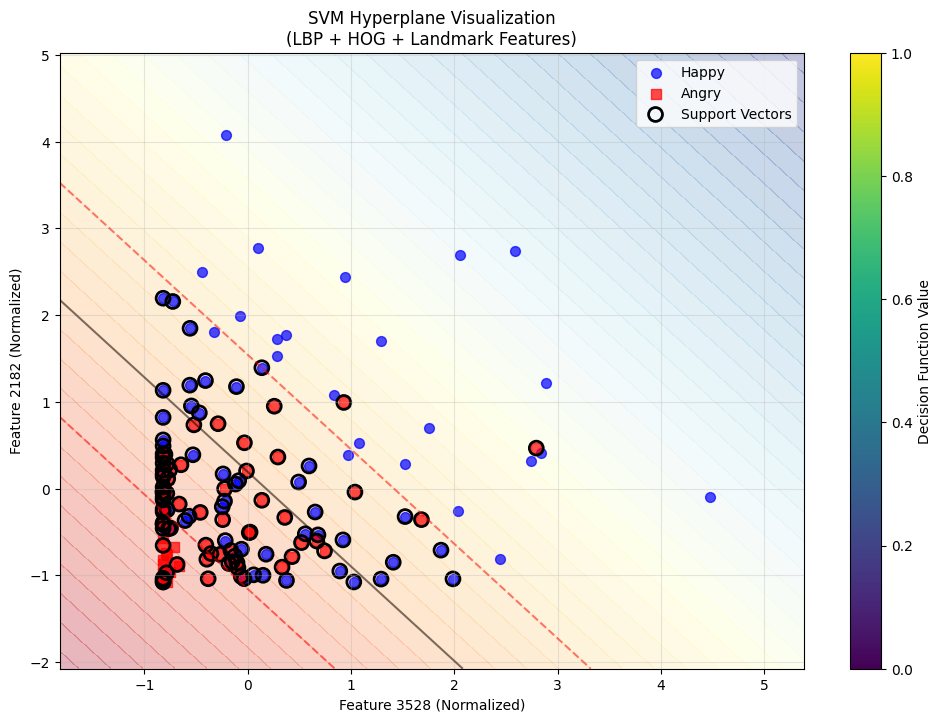


Displaying sample images...


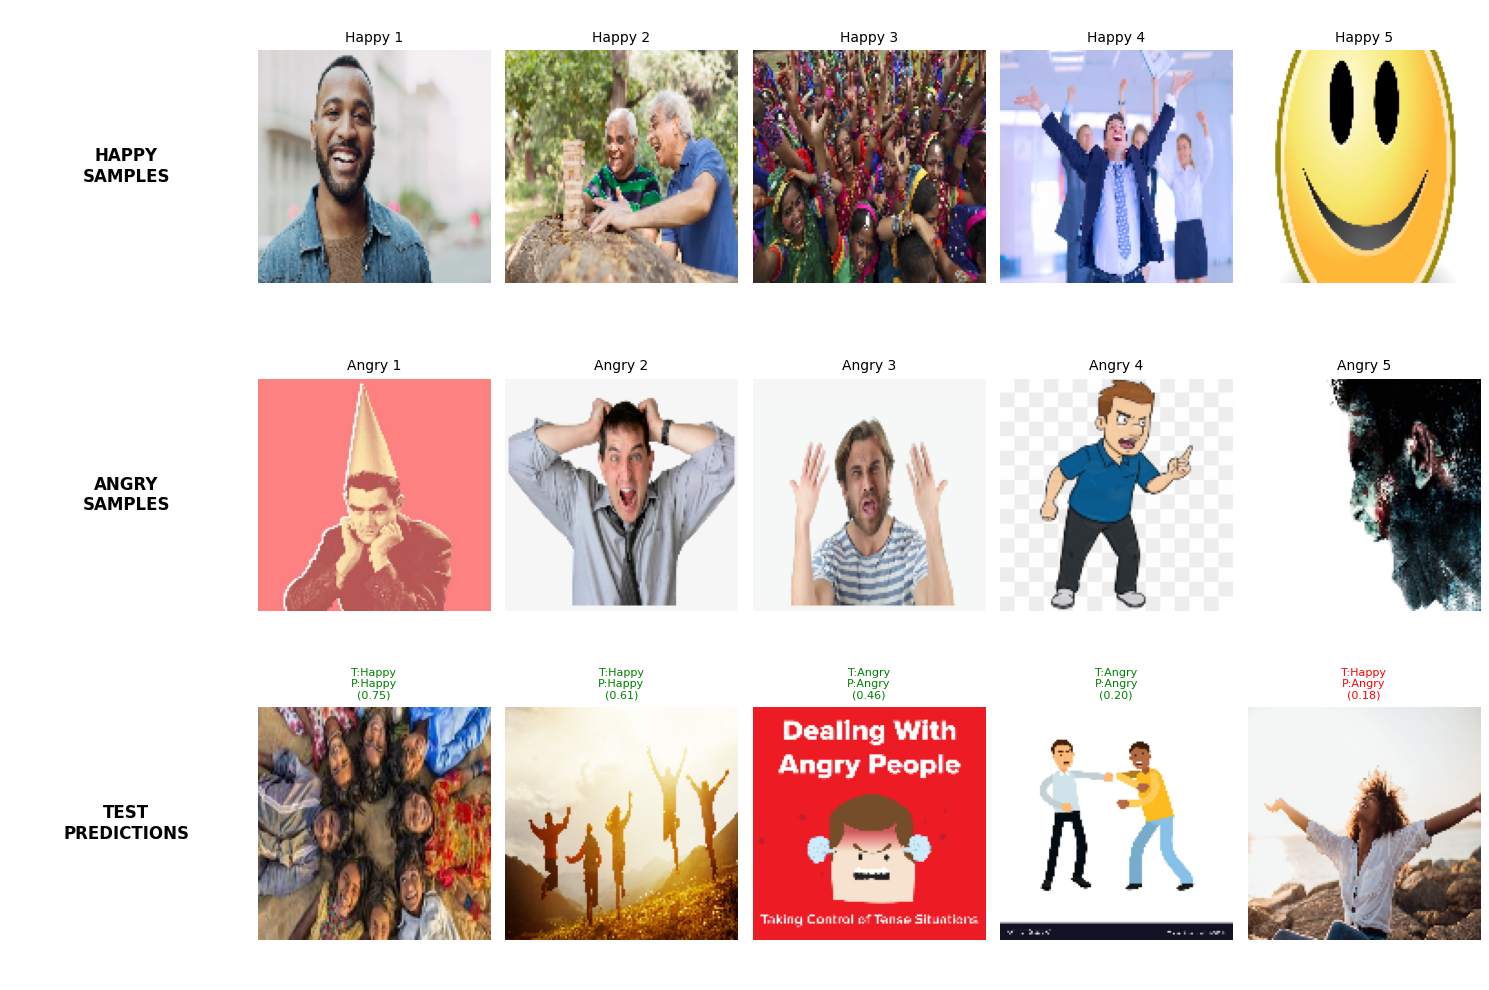

In [23]:
# Visualize hyperplane
print("\nVisualizing SVM hyperplane...")

# # Select most discriminative features for visualization
# #feature_importance = np.abs(np.corrcoef(X_train.T, y_train)[:-1, -1])
# feature_importance = np.abs(np.corrcoef(X_train.T, y_train)[:-1, -1])
# top_features = np.argsort(feature_importance)[-2:]

# Hitung korelasi
correlation = np.corrcoef(X_train.T, y_train)[:-1, -1]

# Buang NaN
valid_indices = ~np.isnan(correlation)
feature_importance = np.abs(correlation[valid_indices])

# Ambil top 2 dari yang valid
# top_valid_indices = np.argsort(feature_importance)[-2:]
top_features = np.argsort(feature_importance)[-2:]
# top_features = np.arange(X_train.shape[1])[valid_indices][top_valid_indices]


print("\nFeature Importance : ")
print(feature_importance)

print("\nTop Features : ")
print(top_features)

visualize_hyperplane_2d(classifier, X_train, y_train, top_features)

# Display sample images from dataset
print("\nDisplaying sample images...")
plt.figure(figsize=(15, 10))

# Show happy samples
plt.subplot(3, 6, 1)
plt.text(0.5, 0.5, "HAPPY\nSAMPLES", ha='center', va='center', 
        fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
plt.axis('off')

for i in range(5):
    if i < len(happy_images):
        plt.subplot(3, 6, i+2)
        img_display = cv2.cvtColor(happy_images[i], cv2.COLOR_BGR2RGB)
        plt.imshow(img_display)
        plt.title(f'Happy {i+1}', fontsize=10)
        plt.axis('off')

# Show angry samples  
plt.subplot(3, 6, 7)
plt.text(0.5, 0.5, "ANGRY\nSAMPLES", ha='center', va='center', 
        fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
plt.axis('off')

for i in range(5):
    if i < len(angry_images):
        plt.subplot(3, 6, i+8)
        img_display = cv2.cvtColor(angry_images[i], cv2.COLOR_BGR2RGB)
        plt.imshow(img_display)
        plt.title(f'Angry {i+1}', fontsize=10)
        plt.axis('off')

# Show some test predictions
plt.subplot(3, 6, 13)
plt.text(0.5, 0.5, "TEST\nPREDICTIONS", ha='center', va='center', 
        fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
plt.axis('off')

emotion_names = {1: 'Happy', -1: 'Angry'}
for i in range(5):
    if i < len(test_images):
        plt.subplot(3, 6, i+14)
        img_display = cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB)
        plt.imshow(img_display)
        
        true_label = emotion_names[test_labels[i]]
        pred_label = emotion_names[int(test_predictions[i])]
        confidence = abs(test_decision_values[i])
        
        color = 'green' if test_predictions[i] == test_labels[i] else 'red'
        plt.title(f'T:{true_label}\nP:{pred_label}\n({confidence:.2f})', 
                fontsize=8, color=color)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
# Final summary
print(f"\n=== Classification Complete ===")
print(f"Dataset: {len(angry_images)} angry + {len(happy_images)} happy images")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Support Vectors: {len(classifier.svm.support_vectors)}")
print(f"SVM Parameters: C={classifier.svm.C}, kernel={classifier.svm.kernel}")


=== Classification Complete ===
Dataset: 86 angry + 100 happy images
Training Accuracy: 93.96%
Test Accuracy: 78.38%
Support Vectors: 120
SVM Parameters: C=1.0, kernel=linear


In [25]:
# Show some individual predictions
print(f"\nSample Test Predictions:")
for i in range(min(10, len(test_images))):
    true_label = emotion_names[test_labels[i]]
    pred_label = emotion_names[int(test_predictions[i])]
    confidence = abs(test_decision_values[i])
    status = "✓" if test_predictions[i] == test_labels[i] else "✗"
    print(f"{status} Test {i+1:2d}: True={true_label:5s}, Pred={pred_label:5s}, "
            f"Confidence={confidence:.3f}")


Sample Test Predictions:
✓ Test  1: True=Happy, Pred=Happy, Confidence=0.755
✓ Test  2: True=Happy, Pred=Happy, Confidence=0.607
✓ Test  3: True=Angry, Pred=Angry, Confidence=0.464
✓ Test  4: True=Angry, Pred=Angry, Confidence=0.198
✗ Test  5: True=Happy, Pred=Angry, Confidence=0.184
✓ Test  6: True=Angry, Pred=Angry, Confidence=0.572
✓ Test  7: True=Happy, Pred=Happy, Confidence=0.418
✗ Test  8: True=Angry, Pred=Happy, Confidence=0.203
✓ Test  9: True=Angry, Pred=Angry, Confidence=0.697
✓ Test 10: True=Happy, Pred=Happy, Confidence=0.364
